## Group Project Report


In [20]:
library(ggplot2)
library(tidymodels)
library(tidyverse)
library(repr)
library(janitor)
library(GGally)
library(readr)
library(dplyr)
library(ISLR)
set.seed(1234)

## Introduction

As first-year students seeking an affordable place to stay during the school year, it is important to get some predicted insights on the housing price to have a better overview of the living expenses not just in Vancouver but also in other Canadian cities, and the rental price can be inferred accordingly. Considering this necessity, this study uses two different models, k-Nearest Neighbours (kNN) and linear regression, and aims to discover which model will provide a better prediction of housing prices using the housing listing dataset from the top 45 most populous cities in Canada. 

KNN regression is a local estimator using its neighbourhood,a non-parametric model, and it produces a flexible line based on the distribution of data. Linear regression, on the other hand, is a global estimator that uses the linear relationship between variables and produces a straight line that illustrates the linear relationship between predictors and responses.

The kNN regression model is expected to be a better tool in predicting housing price than the linear regression model. 

## Methods & Results

    We first read the data and wrangle it by choosing the number of beds and baths greater than 0. We figured that the number_baths was the best predictor compared to other predictors for the linear regression model, so we decided to use it as the predictor against the housing price. This makes sense since a house with a high ratio between the number of beds and baths would have its value lower than those with a relatively equal number of beds and baths. Although logging the price would produce more interpretable visualizations and a lower RMSE, we still kept the housing price at its initial value because if we were to calculate in the exponent form, a small difference in the RMSE value would provide a huge difference in the prediction error. 

    For the kNN regression model, we accounted for the median family income, number of beds and baths as our predictors since they are both important factors in predicting the household value.

Table 1. Clean dataset with number of beds and baths greater than 0

In [21]:
url <- "https://raw.githubusercontent.com/slappyslop/dsci-100-002-033/main/data/HouseListings-Top45Cities-10292023-kaggle.csv"
download.file(url, "data/HouseListings-Top45Cities-10292023-kaggle.csv")
housing_raw <- read_csv("data/HouseListings-Top45Cities-10292023-kaggle.csv") |> clean_names()
housing_filter <- housing_raw |> filter(number_beds > 0 & number_baths > 0)
housing_clean <- housing_filter |> filter(!(city %in% c("Saskatoon", "Winnipeg", "Nanaimo", "Regina") & province == "Ontario"))
housing_clean

Rows: 35768 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): City, Address, Province
dbl (7): Price, Number_Beds, Number_Baths, Population, Latitude, Longitude, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


city    price   address                        number_beds number_baths
1     Toronto  779900 #318 -20 SOUTHPORT ST          3           2           
2     Toronto  799999 #818 -60 SOUTHPORT ST          3           1           
3     Toronto  799900 #714 -859 THE QUEENSWAY        2           2           
4     Toronto 1200000 275 MORTIMER AVE               4           2           
5     Toronto  668800 #420 -388 RICHMOND ST          1           1           
6     Toronto  669900 #817 -151 DAN LECKIE WAY       2           1           
7     Toronto  699000 #1107 -438 KING ST W           2           2           
8     Toronto  978000 #2708 -20 EDWARD ST            3           2           
9     Toronto  958000 #4616 -386 YONGE ST            2           2           
10    Toronto 1899000 #2713 -155 YORKVILLE AVE       2           3           
11    Toronto  559900 #1113 -80 MILL ST              2           1           
12    Toronto  498800 #517 -55 EAST LIBERTY ST       1           1           
13    Toronto 1450000 45 BARTLETT AVE                4           2           
14    Toronto  650000 ##1902 -1926 LAKE SHORE BLVD W 2           1           
15    Toronto  745000 ##812 -103 THE QUEENSWAY       2           2           
16    Toronto  784900 #106 -10 WILBY CRES            3           2           
17    Toronto  998000 3065 WESTON RD                 4           2           
18    Toronto  989900 468 MILVERTON BLVD             4           2           
19    Toronto 1099000 #1816 -35 MERCER ST            3           2           
20    Toronto  590000 #1720 -36 LISGAR ST W          2           2           
21    Toronto  899900 #2 -350 GERRARD ST E           2           2           
22    Toronto  585000 #205 -133 WYNFORD DR           2           1           
23    Toronto  899000 117 WYNDCLIFF CRES             3           2           
24    Toronto  488000 #1213 -195 REDPATH AVE         1           1           
25    Toronto  650000 #801 -100 HAYDEN ST            2           2           
26    Toronto  498000 #812 -600 FLEET ST             2           1           
27    Toronto 1595000 15 LAURIER AVE                 3           3           
28    Toronto  718000 #5008 -2221 YONGE ST           1           1           
29    Toronto 1350000 #1203 -63 ST CLAIR AVE W       2           2           
30    Toronto  999000 #1808 -126 SIMCOE ST           3           2           
⋮     ⋮       ⋮       ⋮                              ⋮           ⋮           
34902 Halifax  598000 5883 Stanley Street            3           1           
34903 Halifax  449000 24 Lynn Road                   3           1           
34904 Halifax  599900 6568 Young Street              3           2           
34905 Halifax  990000 2092 Beech Street              4           4           
34906 Halifax  429900 201 60 Walter Havill Drive     2           2           
34907 Halifax  650000 6497 Bayers Road               2           2           
34908 Halifax  650000 6487 Bayers Road               4           3           
34909 Halifax  599900 204 5355 Russell Street        2           2           
34910 Halifax  599000 31 Flatrock Crescent           4           4           
34911 Halifax  849999 6284 Allan Street              4           3           
34912 Halifax  850000 2659 Connolly Street           2           3           
34913 Halifax  599900 629 Cowie Hill Road            3           4           
34914 Halifax  895000 1 Rockwood Avenue              4           3           
34915 Halifax  679000 6371 Norwood Street            2           1           
34916 Halifax  739770 1 0 Old Sambro Road            4           3           
34917 Halifax  599000 29 Flatrock Crescent           4           4           
34918 Halifax  459900 401 60 Walter Havill Drive     2           2           
34919 Halifax 6995000 6944 Armview Avenue            4           5           
34920 Halifax  879900 2093 Beech Street              4           3           
34921 Halifax  605000 3308 A

Then we split the cleaned dataset into training set and testing set.

In [38]:
set.seed(1234)
housing_split <- initial_split(housing_clean, prop = 0.75, strata = price)
training <- training(housing_split)
testing <- testing(housing_split)

### 1. Linear Regression

We first attempted to make a linear regression of price against one of the variables, we also made our own predictors which included the ratio of beds to bathrooms and sum of beds and bathrooms. In order to see the feasibility of this, we used a pairplot through the following code. Unfortunately, this code makes the kernel crash, and so this was done using RStudio on my (Shravan) local machine

In [39]:
training <- training |> select(-population, -longitude, -latitude, -address, -city, -province)
testing <- testing |> select(-population, -longitude, -latitude, -address, -city, -province)



In [40]:
training_full <- training |> mutate(sum = number_beds + number_baths, ratio = number_beds/number_baths,)
testing_full <- testing |> mutate(sum = number_beds + number_baths, ratio = number_beds/number_baths, )

training


price   number_beds number_baths median_family_income
1     439000  2           1             97000              
2     438000  2           1             97000              
3     448800  3           2             97000              
4     468500  1           1             97000              
5      45000  3           5             97000              
6     399000  1           1             97000              
7     449000  1           1             97000              
8     459900  3           2             97000              
9     456999  3           3             97000              
10    415000  1           1             97000              
11    456999  2           1             97000              
12    419900  2           1             97000              
13    425000  2           1             97000              
14    449900  1           1             97000              
15    369900  1           1             97000              
16    425000  2           3             90000              
17    369900  1           1             90000              
18    453000  1           1             90000              
19    459000  1           1             90000              
20    318000  1           1             90000              
21    428000  1           1             90000              
22    249900  1           1             90000              
23    390000  1           1             90000              
24    459900  1           1             90000              
25    449900  4           3            100000              
26    469900  3           2            100000              
27    459900  3           3            100000              
28    199900  4           2            100000              
29    309900  4           4            100000              
30    445000  2           2            100000              
⋮     ⋮       ⋮           ⋮            ⋮                   
26167 1950000  3           1           76000               
26168 1500000  4           3           76000               
26169 1200000  3           1           76000               
26170 3300000  7           3           76000               
26171 1199000  3           2           76000               
26172 1590000  4           2           76000               
26173 1250000  4           2           76000               
26174 1199000  3           2           76000               
26175 1590000  4           2           76000               
26176 1450000  4           1           76000               
26177 1250000  4           2           76000               
26178 1199000  3           2           76000               
26179 1590000  4           2           76000               
26180 1450000  4           1           76000               
26181 1250000  4           2           76000               
26182 1199000  3           2           76000               
26183 1590000  4           2           76000               
26184 1250000  4           2           76000               
26185 1884015  4           2           65000               
26186 1125000  3           1           65000               
26187 2199000 18          12           65000               
26188 1995000  5           3           65000               
26189 1349000  4           2           76500               
26190 1197000  4           3           76500               
26191 1750000  3           4           76500               
26192 1250000  4           3           86753               
26193 1500000  3           4           86753               
26194 1249900  9           3           86753               
26195 6995000  4           5           86753               
26196 1799900  5           3           86753

## MAKES THE KERNEL CRASH
price_pairplot <- training_full|> 
  ggpairs(
    lower = list(continuous = wrap('points', alpha = 0.4)),
    diag = list(continuous = "barDiag")
  ) +
  theme(text = element_text(size = 20))
"
price_pairplot

We discovered that the correlation coefficient was highest with `sum` and `number_baths` being the best linear predictors of price (0.423 and 0.471). The only other predictor that was non-colinear to `number_baths` was `median_family_income`, howeveer this had a coefficient of 0.053, and so we decided that for the linear regression the only predictor we would use was `number_baths`.

In [41]:
lm_spec <- linear_reg() |> set_engine("lm") |> set_mode("regression")
lm_recipe <- recipe(price ~ number_baths, data = training_full)
lm_fit <-  workflow() |> add_recipe(lm_recipe) |> 
  add_model(lm_spec) |> 
  fit(data = training_full)
lm_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  number_baths  
      -17159        374799  


In [42]:
lm_test_results <- lm_fit |>
  predict(testing_full) |>
  bind_cols(testing_full) |>
  metrics(truth = price, estimate = .pred)
lm_test_results

.metric .estimator .estimate   
1 rmse    standard   8.094921e+05
2 rsq     standard   2.599562e-01
3 mae     standard   4.502335e+05

This approach gives us an RMSE value of `809292.1`.

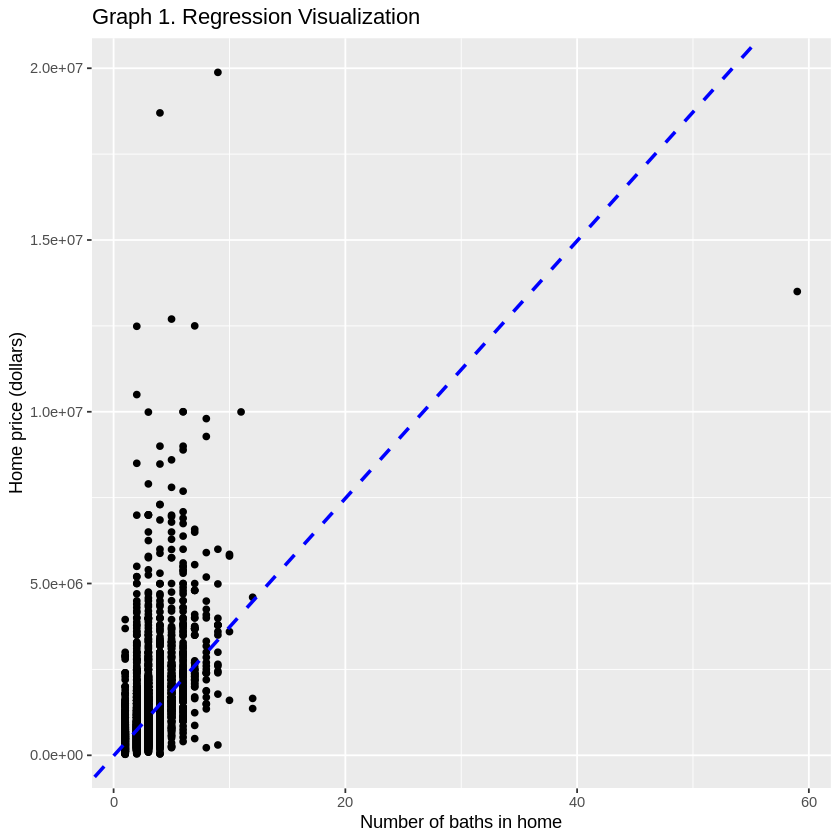

In [47]:
lm_plot <- ggplot(testing_full, aes(x = number_baths , y = price)) + 
  geom_point()+ 
  geom_abline(intercept = -17159, slope =  374799 ,linetype = "dashed", color = "blue", size = 1) +
  labs(y = "Home price (dollars)", x = "Number of baths in home") +
  ggtitle("Graph 1. Regression Visualization")
lm_plot

A closer look at where the majority of the data is

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


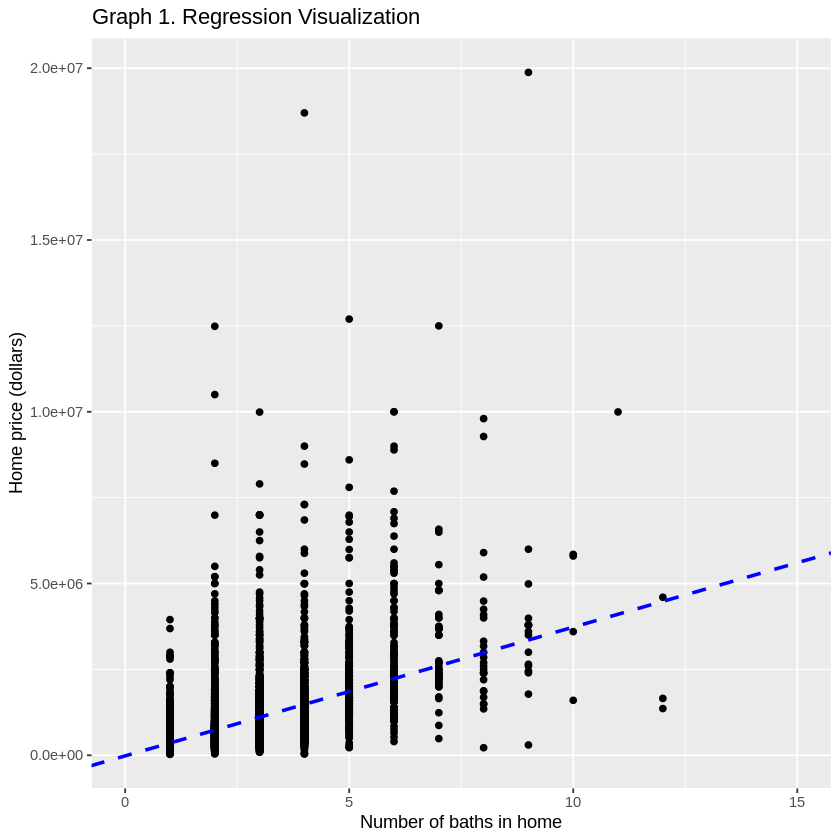

In [50]:
lm_plot_2 <- ggplot(testing_full, aes(x = number_baths , y = price)) + 
  geom_point()+ 
  geom_abline(intercept = -17159, slope =  374799 ,linetype = "dashed", color = "blue", size = 1) +
  labs(y = "Home price (dollars)", x = "Number of baths in home") + xlim(0, 15)+
  ggtitle("Graph 1. Regression Visualization")

lm_plot_2

### 2. KNN  Regression

We then performed kNN regression model to visualize the correlation between the housing price and the number of beds and baths in each household. We chose the neighbourhood from 1 to 100 with an interval of 10 to better see the difference in the RMSE mean values. 
We first set the recipe to have the price predicted from the training data by the median family income, number of beds, and number of baths. We then set the model as regression and created a workflow with the chosen number of neighbours.

In [53]:
training_full

price   number_beds number_baths median_family_income sum ratio    
1     439000  2           1             97000               3   2.0000000
2     438000  2           1             97000               3   2.0000000
3     448800  3           2             97000               5   1.5000000
4     468500  1           1             97000               2   1.0000000
5      45000  3           5             97000               8   0.6000000
6     399000  1           1             97000               2   1.0000000
7     449000  1           1             97000               2   1.0000000
8     459900  3           2             97000               5   1.5000000
9     456999  3           3             97000               6   1.0000000
10    415000  1           1             97000               2   1.0000000
11    456999  2           1             97000               3   2.0000000
12    419900  2           1             97000               3   2.0000000
13    425000  2           1             97000               3   2.0000000
14    449900  1           1             97000               2   1.0000000
15    369900  1           1             97000               2   1.0000000
16    425000  2           3             90000               5   0.6666667
17    369900  1           1             90000               2   1.0000000
18    453000  1           1             90000               2   1.0000000
19    459000  1           1             90000               2   1.0000000
20    318000  1           1             90000               2   1.0000000
21    428000  1           1             90000               2   1.0000000
22    249900  1           1             90000               2   1.0000000
23    390000  1           1             90000               2   1.0000000
24    459900  1           1             90000               2   1.0000000
25    449900  4           3            100000               7   1.3333333
26    469900  3           2            100000               5   1.5000000
27    459900  3           3            100000               6   1.0000000
28    199900  4           2            100000               6   2.0000000
29    309900  4           4            100000               8   1.0000000
30    445000  2           2            100000               4   1.0000000
⋮     ⋮       ⋮           ⋮            ⋮                    ⋮   ⋮        
26167 1950000  3           1           76000                 4  3.000000 
26168 1500000  4           3           76000                 7  1.333333 
26169 1200000  3           1           76000                 4  3.000000 
26170 3300000  7           3           76000                10  2.333333 
26171 1199000  3           2           76000                 5  1.500000 
26172 1590000  4           2           76000                 6  2.000000 
26173 1250000  4           2           76000                 6  2.000000 
26174 1199000  3           2           76000                 5  1.500000 
26175 1590000  4           2           76000                 6  2.000000 
26176 1450000  4           1           76000                 5  4.000000 
26177 1250000  4           2           76000                 6  2.000000 
26178 1199000  3           2           76000                 5  1.500000 
26179 1590000  4           2           76000                 6  2.000000 
26180 1450000  4           1           76000                 5  4.000000 
26181 1250000  4           2           76000                 6  2.000000 
26182 1199000  3           2           76000                 5  1.500000 
26183 1590000  4           2           76000                 6  2.000000 
26184 1250000  4           2           76000                 6  2.000000 
26185 1884015  4           2           65000                 6  2.000000 
26186 1125000  3           1           65000                 4  3.000000 
26187 2199000 18          12           65000                30  1.500000 
26188 1995000  5           3           65000                 8  1.666667 
26189 1349

In [52]:
set.seed(1234)
housing_recipe <- recipe(price ~ ., data = training_full) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

housing_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

housing_vfold <- vfold_cv(training_full, v = 5, strata = price)

housing_workflow <- workflow() |>
  add_recipe(housing_recipe) |>
  add_model(housing_spec)

tuned_housing <- housing_workflow |>
  tune_grid(resamples = housing_vfold, grid = tibble(neighbors = seq(from = 1, to = 100, by = 10))) |>
  collect_metrics()|>
  filter(.metric == "rmse")

tuned_housing


neighbors .metric .estimator mean      n std_err  .config              
1   1        rmse    standard   1055506.3 5 22621.23 Preprocessor1_Model01
2  11        rmse    standard    932321.9 5 29121.18 Preprocessor1_Model02
3  21        rmse    standard    907071.3 5 28838.57 Preprocessor1_Model03
4  31        rmse    standard    893916.6 5 27350.54 Preprocessor1_Model04
5  41        rmse    standard    887024.8 5 27363.48 Preprocessor1_Model05
6  51        rmse    standard    885092.0 5 28182.94 Preprocessor1_Model06
7  61        rmse    standard    883843.1 5 28553.14 Preprocessor1_Model07
8  71        rmse    standard    882390.6 5 29044.09 Preprocessor1_Model08
9  81        rmse    standard    882343.4 5 29355.95 Preprocessor1_Model09
10 91        rmse    standard    882422.1 5 28908.99 Preprocessor1_Model10

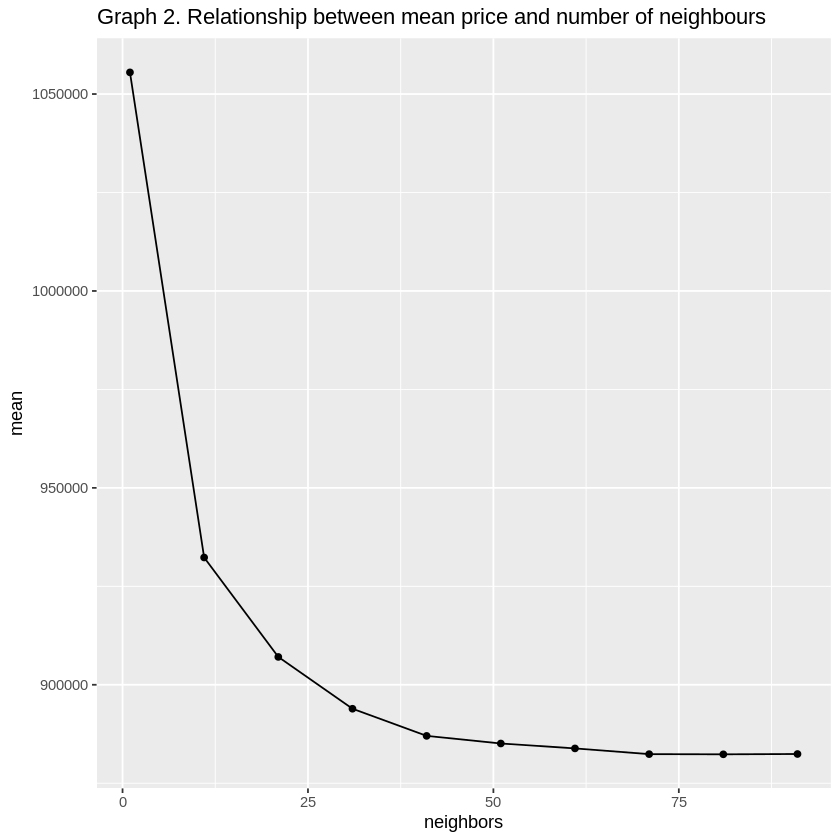

In [54]:
ggplot(tuned_housing, aes(x = neighbors, y = mean)) + geom_point() + geom_line() +
ggtitle("Graph 2. Relationship between mean price and number of neighbours")

We can see a very clear issue here. The way the kNN algorithm works is that it simply finds the city (`median_family_income`), `number_beds` and `number_baths` and takes the average of a number of similar listings based on our value of k. Of course, a 2 bedroom in Vancouver in a downtown skyscraper would have a very different price to a 2 bedroom in East Van. Our dataset does not account for this and this places a large factor in the large errors.

## Discussion

The results showed that the kNN model would be the best model used to predict household value since it accounts for all predictors that have a direct effect on the price, such as using the family income to find the best house with a reasonable number of beds and baths.
